# NRP Motion Challange - Group 5
The Goal of the Challange is to hit the ball as far as possible


In [1]:
# disable global logging from the virtual coach
import logging
logging.disable(logging.INFO)
logging.getLogger('rospy').propagate = False
logging.getLogger('rosout').propagate = False

In [2]:
# log into the virtual coach, update with your credentials
try:
    from hbp_nrp_virtual_coach.virtual_coach import VirtualCoach
    vc = VirtualCoach(environment='local')
except ImportError as e:
    print(e)
    print("You have to start this notebook with the command:\
          cle-virtual-coach jupyter notebook")
    raise e

### The Robot
Here is the swing configuration. We will change the initial time for acceleration

### The (additional) transfer function

To record data from the experiment, we add a special type of transfer functions: **MapCSVRecorder**..
You could also add this transfer functions as a python file in the **Experiments/my_first_experiment** folder and reference it in the **.bibi**, the results would be identical.

In [3]:
record_ball_tf = \
'''
# Imported Python Transfer Function
import numpy as np
import sensor_msgs.msg

@nrp.MapCSVRecorder("ball_recorder", filename="ball_position.csv",
                    headers=["Time", "px", "py", "pz"])
@nrp.Robot2Neuron()
def record_ball_csv(t, ball_recorder):
    from rospy import ServiceProxy
    from gazebo_msgs.srv import GetModelState

    model_name = 'ball'
    state_proxy = ServiceProxy('/gazebo/get_model_state',
                                    GetModelState, persistent=False)
    ball_state = state_proxy(model_name, "world")

    if ball_state.success:
        current_position = ball_state.pose.position
        ball_recorder.record_entry(t,
                                   current_position.x, 
                                   current_position.y, 
                                   current_position.z)
'''

## Running the experiment with default weights

Run the experiment with the default weights, and save the resulting CSV file

In [4]:
swing_tf = '''
# Imported Python Transfer Function
import numpy as np
@nrp.MapSpikeSink("motors", nrp.brain.motors, nrp.leaky_integrator_alpha)
@nrp.MapRobotPublisher('arm_pitch', Topic('/robot/hollie_real_left_arm_2_joint/cmd_pos', std_msgs.msg.Float64))
@nrp.Neuron2Robot()
def swing(t, motors, arm_pitch):
    # set arm to initial state
    arm_pitch.send_message(std_msgs.msg.Float64(-1.5))#* motors.voltage
    # activate Arm when ball is in position and move to end state
    if t > {}: # 1.3
        arm_pitch.send_message(std_msgs.msg.Float64(-0.1))
'''

### Configuring the joint
we changed the joint **velocity-Limit from 1 to 10**
```xml
<joint name='hollie_real_left_arm_2_joint' type='revolute'>
      <child>COL_COL_COL_VIS_VIS_VIS_VIS_VIS_VIS_VIS_VIS_VIS_hollie_real.001</child>
      <parent>COL_COL_COL_VIS_VIS_VIS_VIS_VIS_VIS_VIS_VIS_VIS_hollie_real.000</parent>
      <axis>
        <xyz>0.99863 0.0523359 -4.37114e-08</xyz>
        <limit>
          <lower>-2864.79</lower>
          <upper>2864.79</upper>
          <effort>1000</effort>
          <velocity>10</velocity>
        </limit>
        <dynamics>
          <damping>1</damping>
          <friction>0</friction>
          <spring_reference>0</spring_reference>
          <spring_stiffness>0</spring_stiffness>
        </dynamics>
        <use_parent_model_frame>1</use_parent_model_frame>
      </axis>
    </joint>
```

In [5]:
swing_file = swing_tf.format(1.3)
print swing_file


# Imported Python Transfer Function
import numpy as np
@nrp.MapSpikeSink("motors", nrp.brain.motors, nrp.leaky_integrator_alpha)
@nrp.MapRobotPublisher('arm_pitch', Topic('/robot/hollie_real_left_arm_2_joint/cmd_pos', std_msgs.msg.Float64))
@nrp.Neuron2Robot()
def swing(t, motors, arm_pitch):
    # set arm to initial state
    arm_pitch.send_message(std_msgs.msg.Float64(-1.5))#* motors.voltage
    # activate Arm when ball is in position and move to end state
    if t > 1.3: # 1.3
        arm_pitch.send_message(std_msgs.msg.Float64(-0.1))



In [5]:
import csv
import tempfile
import time
import os

# this name has to match the name passed in the CSV transfer function
csv_name = 'ball_position.csv'


def save_position_csv(sim, datadir):
    with open(os.path.join(datadir, csv_name), 'wb') as f:
        cf = csv.writer(f)
        #################################################
        # Insert code here:
        # get the CSV data from the simulation
        #################################################
        csv_data = sim.get_csv_data(csv_name) #solution
        cf.writerows(csv_data)
    
# The function make_on_status() returns a on_status() function
# This is called a "closure": 
# it is here used to pass the sim and datadir objects to on_status()
def make_on_status(sim, datadir):
    def on_status(msg):
        print("Current simulation time: {}".format(msg['simulationTime']))
        if msg['simulationTime'] == 3.0 and sim.get_state() == 'started':
            #################################################
            # Insert code here:
            # 1) pause the simulation, 
            # 2) save the CSV file
            # 3) stop the simulation 
            #################################################
            sim.pause()  #solution
            save_position_csv(sim, datadir)
            sim.stop() #solution
            print("Trial terminated - saved CSV in {}".format(datadir))
            
    return on_status
        
def run_experiment(datadir, time_weight):
    #################################################
    # Insert code here:
    # 1) launch the experiment
    # 2) add the status callback
    # 3) add the parametrized brain file
    # 4) add the extra CSV TF
    # 5) start the simulation
    #################################################
    swing_file = swing_tf.format(time_weight)
    
    sim = vc.launch_experiment('ExDMotionChallenge') #solution
    sim.register_status_callback(make_on_status(sim, datadir)) #solution
    sim.add_transfer_function(record_ball_tf) #solution
    sim.add_transfer_function(swing_file) #solution
    sim.start()
    return sim
    
tmp_folder = tempfile.mkdtemp()
sim=run_experiment(datadir=tmp_folder, time_weight=1.3)

Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 2
Current simulation time: 2
Current simulation time: 3
Trial terminated - saved CSV in /tmp/tmpTMsxGY
Current simulation time: 3


If everything went fine, the csv data got saved to a **tempdir** in your **/tmp/**:

In [6]:
csv_file = os.path.join(tmp_folder, csv_name)
print("Recorded the following csv file: {}".format(csv_file))

Recorded the following csv file: /tmp/tmpTMsxGY/ball_position.csv


In [7]:
import pandas
ball_csv = pandas.read_csv(csv_file)
ball_csv

,Time,px,py,pz
0,1.00,0.000000,5.000000,2.100000
1,1.02,0.000000,5.000000,2.097942
2,1.04,0.000000,4.977895,2.099332
3,1.06,0.000000,4.913684,2.110838
4,1.08,0.000000,4.807368,2.132459
5,1.10,0.000000,4.658947,2.164194
6,1.12,0.000000,4.468421,2.206045
7,1.14,0.000000,4.257895,2.250642
8,1.16,0.000000,4.047368,2.291320
9,1.18,0.000000,3.836842,2.328077


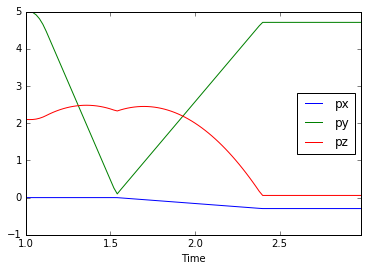

In [8]:
%matplotlib inline
ball_csv=ball_csv.set_index('Time')
ball_csv.plot()

## Optimizing the synaptic weight

We define the objective function as being the accumulated **y** position. Let's run many trials with different time_weights and see the evolution of accumulated **y** position. For example, with this current trial of time_weight 1.3, the accumulated **y** is:

In [9]:
ball_csv.py.max()


321.82736664667334

Run the experiment again with different time_weights and plot the results. After a view trials you can see that the maximum is in the area of 1.4 sec.

Current simulation time: 0
Current simulation time: 1
Current simulation time: 1
Current simulation time: 2
Current simulation time: 3
Trial terminated - saved CSV in /tmp/tmpKhCOjZ
Current simulation time: 3
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 2
Current simulation time: 3
Trial terminated - saved CSV in /tmp/tmpLCXI4T
Current simulation time: 3
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 1
Current simulation time: 2
Current simulation time: 3
Trial terminated - saved CSV in /tmp/tmpbEZJ7a
Current simulation time: 3
Current simulation time: 0
Current simulation time: 1
Current simulation time: 1
Current simulation time: 2
Current simulation time: 3
Trial terminated - saved CSV in /tmp/tmpPniGSW
Current simulation time: 3
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 2
Current simulation time: 3
Tr

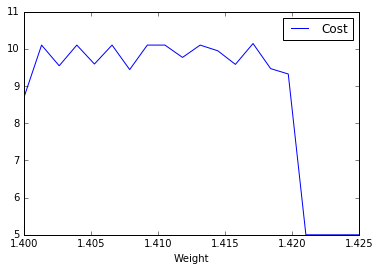

In [13]:
import numpy as np
import time

n_trials =  20
trial_weights = np.linspace(1.4, 1.425, n_trials)
trial_ball_csv = [tempfile.mkdtemp() for i in range(n_trials)]
#################################################
# Insert code here:
# 1) run the experiments with all the trial_weights
# 2) compute the fitness of each trial
# 3) plot your results
#################################################
weight_costs = []
for i in range(n_trials):
    run_experiment(trial_ball_csv[i], time_weight=trial_weights[i])
    csv_file = os.path.join(trial_ball_csv[i], csv_name)
    while not os.path.isfile(csv_file):
        time.sleep(1)
    ball_csv = pandas.read_csv(csv_file)
    weight_costs.append(ball_csv.py.max())
    time.sleep(10)

weight_costs_df = pandas.DataFrame({
    'Weight': pandas.Series(trial_weights),
    'Cost': pandas.Series(weight_costs)
})
weight_costs_df.set_index('Weight').plot()